# Crisp Data Mining (CRISP-DM) : Supervised learning

The questions to be answered at this stage:

- What kind of model architecture best fits our data?
- How well does the model perform technically?
- Could we improve that performance?
- How the performance of the model is evaluated?

In this code there is -- <font color = darkorchid><i>supervised learning</i></font> -- for classification and regression tasks.

### packages

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning package - scikit-learn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import Ridge

# Show the plots inline in the notebook
%matplotlib inline

______________
## <font color = lightcoral>1. Classification using k-nearest neighbors </font> 

<font color = darkorchid><b>K-Nearest Neightbors (k-NN) algorithm</b></font> is one of the classic supervised machine learning algorithms. It assumes that similar points are close to each other. 

The k-NN algorithm is used to **predict the presence of cardiovascular disease** using all the other variables as <font color = darkorchid><b>features</b></font> in the data set. So, the target variable is <font color = darkorchid><b>cardio</b></font>.

***1 A)*** 

Printing the first 10 rows to check that everything is ok.


In [2]:
# Path for the data
data_path = 'ex2_cardio_data.csv'

# Create a dataframe
cardio_data = pd.read_csv(data_path, dtype='int')

In [3]:
### Code - 10 first row
cardio_data.head(10)

,age,sex,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol_at_risk,cholesterol_elevated,cholesterol_normal,gluc_at_risk,gluc_elevated,gluc_normal
0,22767,0,162,75,120,80,0,0,1,0,0,0,1,0,0,1
1,19102,0,164,80,140,90,0,0,1,0,0,0,1,0,0,1
2,23251,0,155,76,130,80,0,0,1,0,0,0,1,0,1,0
3,22651,1,169,65,120,80,0,0,1,0,0,0,1,0,0,1
4,21770,1,171,67,160,100,0,0,0,1,0,0,1,0,0,1
5,14651,1,170,70,120,80,0,0,1,0,0,0,1,0,0,1
6,17391,0,152,65,110,70,0,0,1,0,0,0,1,0,0,1
7,14792,0,165,65,120,70,0,0,1,0,0,0,1,0,0,1
8,15982,1,180,81,110,70,1,0,1,0,0,0,1,0,0,1
9,19589,0,156,60,120,90,0,0,1,0,0,0,1,0,0,1


----

***1 B)*** 

Producing training and test data by divide the data **randomly** into training (80%) and test (20%) sets using train-test split <font color = darkorchid><b>train-test split</b></font>.

In [4]:
features = cardio_data.copy() # making a copy to save the original data
features = features.drop(columns=['cardio']) # droping cardio from the features
labels = cardio_data['cardio'].copy() # making a copy of cardio for labels

# this is what I found on the internet : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2,
                                                    random_state=42, stratify=labels)

In [5]:
### Code - Train-test split

# this is the idea I came up with first without train_test_split
training_data = cardio_data.sample(frac=0.8, random_state=42) # making training set with 80% portion
testing_data = cardio_data.drop(training_data.index) # making test set by skipping training data
labels_training = labels.drop(testing_data.index) # making labels for train set by skipping test data
labels_testing = labels.drop(training_data.index) # making labels for test set by skipping train data

----------

***1 C)*** 

Scaling the numeric features. 

In [6]:
### Code - Standardization
numeric_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo'] # specifing numeric features

scaler = StandardScaler() # making a scaler based on standard normalization
scaler.fit(training_data[numeric_features]) # making a tramsformation based on training data
training_data[numeric_features] = scaler.transform(training_data[numeric_features]) # scaling training data
testing_data[numeric_features] = scaler.transform(testing_data[numeric_features]) # scaling test data

<font color = red>  KNN Algorithm works based on Euclidean distance. If we dont standardalize the dataset, samples might be too close or too far and this affects the classification (Cardio 1 or 2).

-------

It's time for us to train the model!

***1 D)*** 

k-NN model with $k=3$, Printing out the confusion matrix.

In [7]:
### Code - kNN classifier
model = KNeighborsClassifier(n_neighbors = 3) # making a knn model with k=3
model.fit(training_data, labels_training) # train the model with training data

result = model.predict(testing_data) # using the model to predict the test set output
array = metrics.confusion_matrix(labels_testing,result) # creating confusion matrix from the result
matrix = pd.DataFrame(array, columns=['Positive', 'Negative'], index=['Positive', 'Negative']) # making cols and index 
matrix # printing matrix

,Positive,Negative
Positive,115,28
Negative,44,13


In [8]:
recall = array[0][0] / (array[0][0] + array[0][1]) # calculating recall with TP and FN
precision = array[0][0] / (array[0][0] + array[1][0]) # calculating precision with TP and FP
# calculating accuracy
accuracy = (array[0][0]+array[1][1]) / (array[0][0] + array[1][1] + array[0][1] + array[1][0])
# printing Recall and Precision and accuracy
print("Recall: ", round(recall,2), " Precision: ", round(precision,2), " Accuracy: ", accuracy) 

Recall:  0.8  Precision:  0.72  Accuracy:  0.64



- 1000 **different** train and test set splits.
- k-NN model (with $k=3$) for each split and save its accuracy.  
- Accuracies plotted in a histogram.
- Results

In [9]:
### Code - 1000 different train-test-splits
all_results = []
for i in range(1000):
    # making the test and train sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2,
                                                        random_state=i, stratify=labels)
    model = KNeighborsClassifier(n_neighbors = 3) # making a knn model with k=3
    model.fit(X_train, y_train) # train the model with training data

    result = model.predict(X_test) # using the model to predict the test set output
    array = metrics.confusion_matrix(y_test,result) # creating confusion matrix from the result
    # accuracy (TP+TN)/(TP+TN+FP+FN)
    accuracy = (array[0][0]+array[1][1]) / (array[0][0] + array[1][1] + array[0][1] + array[1][0])
    all_results += [accuracy] # saving accuracy

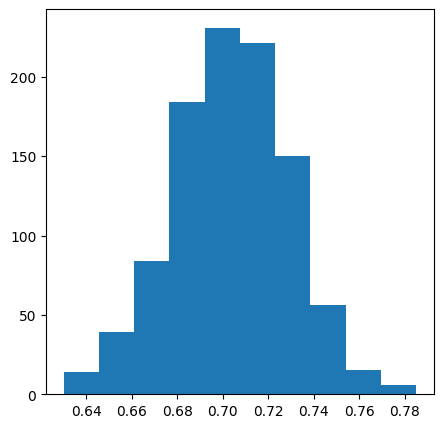

In [10]:
plt.figure(figsize = (5,5)) # creating a figure of size 5 * 5
plt.hist(all_results) # creating a histogram of results
plt.show() # presenting the figure and histogram 

<font color = red> Based on confusion matrix, we have 126 TP, 24 FN, 42 FP, and 8 TN. We can calculate Recall and Precision. For an acceptable model, both of these values should not be too small.

I think the differences in results are because of different ways of spiliting. In some cases there might be more posetive cases than negative ones. This leads to a larger recall but not a satisfactory precision or accuracy. In cases with majoraty of negative cases the same thing happens but with a small recall and a larger precision. 

For the accuracy of the model, I will go with the median (tallest in histogram). Because we ran the model 1000 times and this makes lots of random groups. We are assuming that we are getting an acceptable number of balanced training data and those are leading to an accuracy. Also the accuracy is larger that the one before (0.67 > 0.64).

------

Evaluation metric: <font color = darkorchid><b>the area under the receiver operating characteristic (AUROC or AUC-ROC)</b></font>.

***1 E)*** 


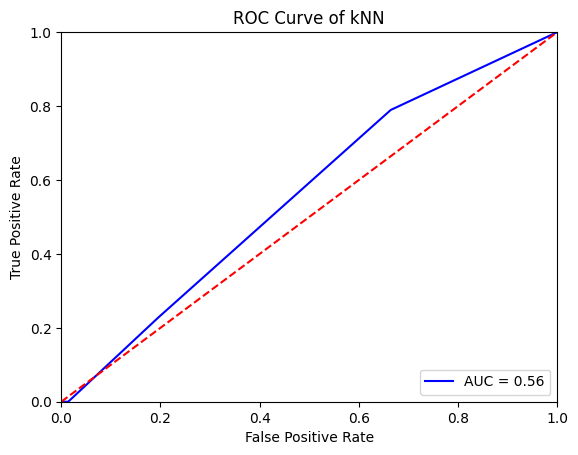

In [11]:
### Code - AUROC and ROC Curves
# Ref: https://github.com/sambid9988/Machine-Learning-with-Python/blob/master/KNN%20with%20auc%20and%20roc%2C%20with%20k%20(elbow%20method).ipynb

from sklearn.metrics import roc_curve,auc 
probas_ = model.fit(training_data, labels_training).predict_proba(testing_data)
fpr, tpr, _ = roc_curve(labels_testing, probas_[:, 1]) # getting FP and TP rates from the result and label
roc_auc = auc(fpr, tpr) # returning the auc score

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc) # ploting the curve and printing AUC score
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--') # creating the red line
plt.xlim([0, 1]) # creating X axe in the range 0 to 1
plt.ylim([0, 1]) # creating Y axe in the range 0 to 1
plt.ylabel('True Positive Rate')  # equal to recall
plt.xlabel('False Positive Rate') # equal to 1 - precision
plt.title('ROC Curve of kNN') # assigning a title to the figure
plt.show() # presenting the figure

<font color = red>  The vertical axis is equal to recall and the horisontal axis is equal to 1 - precision. We like the curve's middle to be at the top-left corner where the true posetive is maximum and false posetive is minimum. My curve shows that one of the false posetive or true posetive rates is not satisfactory and the model is not well-trained.</font>

__________
## <font color = royalblue> 2. Classification accuracy using leave-one-out cross validation

<font color = red> leave-one-out cross validation helps us to maximize the training data set to train our model in the best way. Because if we seperate a group (like 20% randomly) we are taking out some minorities that affect the trained wrights. So, we are taking the smallest group possible (only 1) and do it for all the samples because the test need to be reliable as well. A single sample for a test is not enough.

---------------

***2 B)***

Prediction of **presence of cardiovascular disease**, using leave-one-out cross validation to estimate the model performance with kNN classifier with $k=3$.

In [13]:
features.shape

(1000, 15)

In [14]:
### Code - Leave-one-out cross validation
# checked this website for help : https://www.statology.org/leave-one-out-cross-validation-in-python/

model = KNeighborsClassifier(n_neighbors = 3) # making a knn model with k=3
cv = LeaveOneOut() #define cross-validation method to use
scores = cross_val_score(model, features, labels, cv=cv) # dividing the data into n sections 
    #(n number of samples ), one sample 
    # is left out of the data set as the test and we train the model with the maximum possible data (n-1)
    # samples and then test it with the one left. We do this for all the samples.
np.mean(np.absolute(scores)) # calculating the mean of all scores

0.707

<font color = red> In this task I used mean to calculate the total accuracy. Because we are using only 1 sample for the test and we expect to have lots of 1 or 0 as the model is going to learn something. Hence, the mode is going to be 0 or 1 that is too much optimistic or pessimistic.

The last two approaches got 0.64 and 0.67. This one got 0.7 which is greater. It seems the model is trained better but we can't tell fo sure, we need to check some other parameters as well.

____________
## <font color = forestgreen> 3. Model selection with leave-one-out cross validation

<font color = darkorchid><b>hyperparameter tuning</b></font>.

Finding *optimal value* for k by training 30 multiple models with k=1 to 30.

***3 )***

$k=1...30$ , leave-one-out cross validation.

In [15]:
### Code - Select best k
# Ref: https://www.youtube.com/watch?v=h3ARWw3uSoE
knn_params = {
    "n_neighbors": range(1,30) # creating the range of the neighbours we want to have
}
model = KNeighborsClassifier() # creating knn model
cv = LeaveOneOut() #define cross-validation method to use
# Using GridSearchCV, we assign the model for it, assign the params we defined before, specifing the 
# scoring method, the LeaveOneOut method, and number of jobs
GSV = GridSearchCV(estimator=model, param_grid=knn_params, 
    n_jobs=1, cv=cv, scoring="accuracy", error_score=0)    
result = GSV.fit(training_data,labels_training) # training GSV to find the best K based on accuracy
model = model.set_params(**result.best_params_) # passing the best params to our model
model.fit(training_data,labels_training) # training the model based on best params
predicts = model.predict(testing_data) # testing the model

# printing the result
print(metrics.classification_report(predicts,labels_testing))
print(metrics.confusion_matrix(predicts,labels_testing))
print(result.best_params_)

P_plot = predicts.copy() # saving for plotting

              precision    recall  f1-score   support

           0       0.98      0.71      0.83       196
           1       0.02      0.25      0.03         4

    accuracy                           0.70       200
   macro avg       0.50      0.48      0.43       200
weighted avg       0.96      0.70      0.81       200

[[140  56]
 [  3   1]]
{'n_neighbors': 18}


<font color = red> K = 18 is the param for classification

The limitation for accuracy will be the number of samples - 1. Because this is the maximum number of neighbours a sample can have.

Based on the precision and recall, we are getting almost negative answers and model is not trained well. The accuracy is more than 50% because most of the data is negative probably.

_____________________

## <font color = darkorange> 5. Comparison of ridge regression and kNN regression </font>

The Boston Housing Dataset variables:

- **CRIM** - per capita crime rate by town
- **ZN** - proportion of residential land zoned for lots over 25,000 sq.ft.
- **INDUS** - proportion of non-retail business acres per town.
- **CHAS** - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- **NOX** - nitric oxides concentration (parts per 10 million)
- **RM** - average number of rooms per dwelling
- **AGE** - proportion of owner-occupied units built prior to 1940
- **DIS** - weighted distances to five Boston employment centres
- **RAD** - index of accessibility to radial highways
- **TAX** - full-value property-tax rate per \$10,000
- **PTRATIO** - pupil-teacher ratio by town
- **B** - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- **LSTAT** - % lower status of the population
- **MEDV** - Median value of owner-occupied homes in \$1000's


The object is to predict **the median house value**. So the target variable is now <font color = darkorchid><b>MEDV</b></font> and all the others are <font color = darkorchid><b>features</b></font>.

In [63]:
# Data path
data_path = 'ex2_boston_housing_data.csv'

# Load the data 
boston_data = pd.read_csv(data_path, dtype='float')

-----------

With regression, we can examine **the relationship between two or more variables**. This relationship is represented by an *equation*, which itself represents how much y changes with any given change of x. So for example, we could use *age* as an independent variable to predict *height* (a dependent variable). 

We start by looking at the relationships between the variables in the given dataset.


***5 A)***

Each feature versus the target variable `MEDV`.

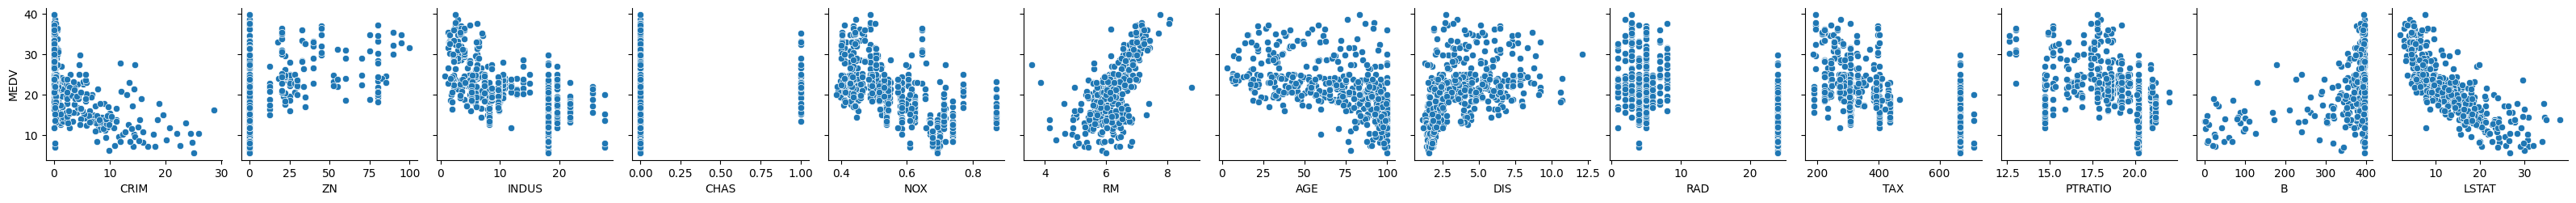

In [64]:
### Code - Scatter plots
X_vars = 'MEDV' # X axe variable
Y_vars = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',  # Y axe variable
          'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
sns.pairplot(boston_data, y_vars=X_vars, x_vars=Y_vars) # ploting scatters using pairplot

<font color = red> In some variables including ZH, CHAS, RAD, TAX, PTRATIO the data is distributed over the 'Y' axe and does not seem that there is a relation between the samples. 

In CRIM, NOX, AGE the value of MEDV decreases when the other variable increases.

In INDUS and LSTAT the value of MEDV increases when the other variable decreases.

IN B Min and Max data are at Max of MEDV.
 </font> 

------
With ridge regression, the hyperparameter called $\lambda$ is used for model selection.


To compare, a loss function called <font color = darkorchid><b>mean absolute error (MAE)</b></font> is used. 



***5 B)***

In [65]:
### Code - Preparation
boston_data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000
mean,2.859473,10.825482,11.178758,0.059957,0.554025,6.203176,68.283084,3.861389,9.400428,407.528908,18.581799,357.492741,13.047259,21.113490
std,5.204950,22.435436,6.810618,0.237662,0.117089,0.591121,28.062858,2.113944,8.657791,167.120323,2.061196,89.711000,6.872562,6.656016
min,0.006320,0.000000,0.740000,0.000000,0.385000,3.561000,2.900000,1.137000,1.000000,187.000000,12.600000,0.320000,1.980000,5.600000
25%,0.082100,0.000000,5.190000,0.000000,0.449000,5.879500,44.700000,2.122300,4.000000,281.000000,17.400000,375.955000,7.580000,16.800000
50%,0.228760,0.000000,9.690000,0.000000,0.538000,6.169000,76.700000,3.317500,5.000000,330.000000,19.100000,392.110000,11.980000,20.800000
75%,3.504645,12.500000,18.100000,0.000000,0.624000,6.539000,93.850000,5.266000,24.000000,666.000000,20.200000,396.900000,17.115000,24.350000
max,28.655800,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,39.800000


<font color = red>We need data prepration. We need to divide labels and features. Also, we are using methods that work on distance for model training. We should scale the numbers as well. In some cases the difference between min and max is less than 1 and in some others is greater than 100. </font> 

In [66]:
### Code - Standardization
features = boston_data.copy() # making a copy to save the original data
features = features.drop(columns=['MEDV']) # droping MEDV from the features
labels = boston_data['MEDV'].copy() # making a copy of MEDV for labels

numeric_features = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE',
                    'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
scaler = StandardScaler() # making a scaler based on standard normalization
scaler.fit(features[numeric_features]) # making a tramsformation based on the data
features[numeric_features] = scaler.transform(features[numeric_features]) # scaling data

------

***5 C)***

Training a ridge regression model and a k-NN regression model. 

For hyperparameters:
- $\lambda=2^{-10}...2^{10}$
- $k=1...30$, leave-one-out cross validation.

In [67]:
### Code - Ridge regression and k-NN regression
alphas = dict()
alphas['alpha'] = 2 * 10**np.linspace(10,-10) # creating lambdas
model = Ridge() # creating regression model
# define model evaluation method
cv = LeaveOneOut() #define cross-validation method to use
# Using GridSearchCV, we assign the model for it, specifing the 
# scoring method, the LeaveOneOut method, and number of jobs
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2,
                                                    random_state=42)

GSV = GridSearchCV(estimator=model, param_grid=alphas,scoring='explained_variance', cv=cv)
result = GSV.fit(X_train, y_train) # training GSV to find the best lambda based on accuracy
model = model.set_params(**result.best_params_) # passing the best params to our model
model.fit(X_train, y_train) # training the model based on best params
predicts = model.predict(X_test) #testing
print(result.best_params_)
# the number of test are less that train, parameters should be in the same size
l = int(predicts.shape[0])
# the difference between the model and training data
print(' train: %.3f' % metrics.mean_squared_error(y_train.iloc[:l], predicts))
# the difference between the model and test data
print(' test: %.3f' % metrics.mean_squared_error(y_test, predicts))

{'alpha': 20000000000.0}
 train: 33.845
 test: 39.682


In [68]:
model = KNeighborsRegressor() # creating k neighbour regression model
cv = LeaveOneOut()
knn_params = {
    "n_neighbors": range(1,30) # creating the range of the neighbours we want to have
}
# Using GridSearchCV, we assign the model for it, assign the params we defined before, specifing the 
# scoring method, the LeaveOneOut method, and number of jobs
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2,
                                                    random_state=42)

GSV = GridSearchCV(estimator=model, param_grid=knn_params, 
                    cv=cv, scoring='explained_variance')    
result = GSV.fit(X_train, y_train) # training GSV to find the best K based on accuracy
model = model.set_params(**result.best_params_) # passing the best params to our model
model.fit(X_train, y_train) # training the model based on best params
predicts_knn = model.predict(X_test) #testing
# printing the result
# the difference between the model and training data
print(' train: %.3f' % metrics.mean_squared_error(y_train.iloc[:l], predicts_knn))
# the difference between the model and test data
print(' test: %.3f' % metrics.mean_squared_error(y_test, predicts_knn))
print(result.best_params_)


 train: 81.345
 test: 11.006
{'n_neighbors': 1}


In [69]:
print(round(metrics.mean_absolute_error(y_test, predicts),2)) # calculating MAE for ride regression
print(round(metrics.mean_absolute_error(y_test, predicts_knn),2)) # calculating MAE for knn

4.75
2.49


<font color = red>
MAE shows the absolute difference between the expected data and the data we got from the model. In gerenal, we try to get models with not a large MAE.

In this case, the MAE of knn is less than the MAE of ride regression. The data is scaled and based on the data range it is not a large number.  I think if we are going to judge based on MAE, knn is better
</font>

------

***5 D)***

Actual labels vs. predicted labels

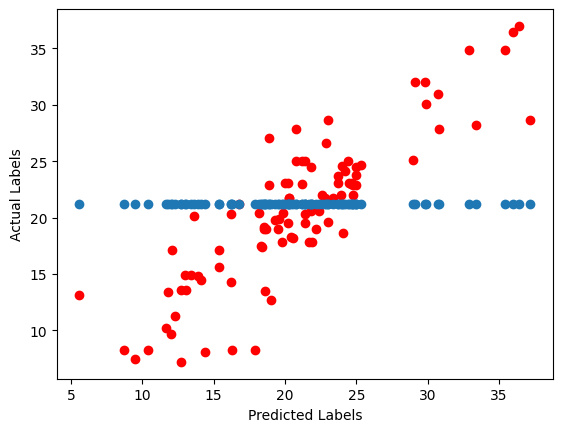

In [70]:
### Code - Plot actual vs predicted labels
plt.ylabel('Actual Labels')  
plt.xlabel('Predicted Labels') 
plt.scatter(y_test, predicts_knn,color='red') #ploting knn in red
plt.scatter(y_test, predicts) # ploting ride in blue

plt.show()

<font color = red> The scatter is showing that the knn model is returning same values for all the data, even if it has less MAE. Rideregression is working better here.

I think ideally the predicted points and the labels should be exactly the same and all the dots should be placed on x=y line. But all the models have errors and this does not happen.